In [1]:
from pathlib import Path
from IPython.display import HTML, display
css = Path("../../../css/rtl.css").read_text(encoding="utf-8")
display(HTML(f"<style>{css}</style>"))


# فصل ۴ — مبانی یادگیری نظارت‌شده
## درس ۱۰: رگرسیون ترتیبی (وقتی ترتیب کلاس‌ها مهم است)

**دوره:** دوره مقدماتی یادگیری ماشین  
**تعداد درس‌های فصل:** ۱۳ درس (درس ۱ … درس ۱۳)

در بسیاری از مسائل یادگیری نظارت‌شده، هدف **دسته‌ای** است اما دسته‌ها **ترتیب طبیعی** دارند. مثال‌ها:

- رضایت مشتری: *خیلی بد < بد < خنثی < خوب < خیلی خوب*
- درجه ریسک اعتباری: *D < C < B < A*
- مراحل شدت بیماری: *مرحله I < مرحله II < مرحله III < مرحله IV*
- امتیاز کیفیت محصول: *1 < 2 < 3 < 4 < 5*

این نوع برچسب‌ها «کلاس‌های اسمی (Nominal)» نیستند (چون ترتیب دارند) و «پیوسته» هم نیستند. در این درس روی مدل‌ها، اهداف، و معیارهای ارزیابی‌ای تمرکز می‌کنیم که از **ترتیب** استفاده می‌کنند تا هم کارایی آماری بهتر شود و هم خطاهای «نزدیک» نسبت به خطاهای «دور» کمتر جریمه شوند (مثلاً پیش‌بینی *۴* به جای *۵* نباید مثل پیش‌بینی *۱* به جای *۵* جریمه شود).

---

### اهداف یادگیری

در پایان این درس باید بتوانید:

1. تفاوت میان هدف **اسمی**، **ترتیبی (Ordinal)** و **پیوسته** را دقیق توضیح دهید و بدانید چرا مهم است.
2. مدل **cumulative link / proportional odds** برای رگرسیون لجستیک ترتیبی را استخراج و تفسیر کنید.
3. دو خط پایه کاربردی (کلاسه‌بندی چندکلاسه و رگرسیون + گرد کردن) را پیاده‌سازی و با مدل ترتیبی مقایسه کنید.
4. از معیارهای مناسب ترتیبی (مثل MAE روی رتبه‌ها و quadratic weighted kappa) استفاده کنید و خروجی‌های مدل (threshold/cutpoint) را تفسیر نمایید.
5. مدل ترتیبی را روی داده‌های جدولی واقعی به‌کار ببرید و از دام‌های رایج (کلاس‌های کم‌نمونه، فروپاشی آستانه‌ها، نشت داده، و ناسازگاری معیار ارزیابی) پرهیز کنید.


## ۱. جایگاه رگرسیون ترتیبی در یادگیری نظارت‌شده

فرض کنید $Y$ هدف و $X \in \mathbb{R}^p$ بردار ویژگی‌ها باشد.

- **کلاسه‌بندی اسمی (Nominal):** $Y \in \{1,\dots,K\}$ بدون ترتیب (مثلاً گونه، رنگ).
- **کلاسه‌بندی/رگرسیون ترتیبی (Ordinal):** $Y \in \{1,\dots,K\}$ با ترتیب $1 \prec 2 \prec \cdots \prec K$ (مثلاً سطح امتیاز).
- **رگرسیون:** $Y \in \mathbb{R}$ پیوسته (مثلاً قیمت، دما).

مسئله ترتیبی معمولاً وقتی رخ می‌دهد که:

1. برچسب‌ها از گسسته‌سازی یک پدیده نهفته پیوسته آمده باشند (مثل «ریسک» یا «کیفیت»)، یا
2. ابزار اندازه‌گیری ذاتاً ترتیبی باشد (مقیاس‌های لیکرت)، یا
3. فرایند تصمیم‌گیری مرحله‌ای باشد (triage level).

بینش کلیدی: **برچسب‌های ترتیبی اطلاعات ساختاری بیشتری نسبت به برچسب‌های اسمی دارند.**  
نادیده گرفتن ترتیب (رفتار مثل چندکلاسه) اتلاف اطلاعات است؛ و رفتار مثل مقدار پیوسته (رگرسیون) می‌تواند فرض فاصله‌های غیرواقعی بین سطوح را تحمیل کند.

### ۱.۱. تابع زیان و «فاصله» بین کلاس‌ها

در کلاسه‌بندی چندکلاسه معمولاً cross-entropy کمینه می‌شود:

$$
\mathcal{L}_{\text{CE}} = -\sum_{i=1}^n \sum_{k=1}^K \mathbf{1}(y_i=k)\,\log p_{ik}.
$$

این زیان تفاوتی بین اشتباه نزدیک و اشتباه دور قائل نمی‌شود. در مسائل ترتیبی، اغلب زیان‌هایی می‌خواهیم که «فاصله» خطا را هم لحاظ کنند.

یک زیان ساده، خطای قدرمطلق روی رتبه‌هاست:

$$
\text{MAE}_{\text{ord}} = \frac{1}{n}\sum_{i=1}^n |y_i - \hat{y}_i|.
$$

و نسخه مربعی:

$$
\text{MSE}_{\text{ord}} = \frac{1}{n}\sum_{i=1}^n (y_i - \hat{y}_i)^2.
$$

البته این معیارها فرض می‌کنند شماره‌گذاری کلاس‌ها نماینده رتبه است (که درست است)، اما هنوز «فاصله برابر» بین سطوح را تضمین نمی‌کند. مدل‌های ترتیبی تلاش می‌کنند ترتیب را رعایت کنند بدون اینکه فاصله برابر را تحمیل کنند.

### ۱.۲. دو خط‌پایه رایج (نادرست ولی مفید)

در عمل دو راه ساده زیاد دیده می‌شود:

1. **رفتار مثل چندکلاسه** (softmax یا OvR) و گزارش accuracy.
2. **رفتار مثل رگرسیون** (پیش‌بینی عدد حقیقی) و سپس گردکردن/بریدن به $\{1,\dots,K\}$.

هر دو می‌توانند baselineهای خوبی باشند، اما هیچ‌کدام ساختار ترتیب را در خود مدل «اجبار» نمی‌کنند.

مدل‌های رگرسیون ترتیبی می‌خواهند:

- یکنواختی **احتمال‌های تجمعی** را نسبت به سطح حفظ کنند،
- آستانه‌های قابل تفسیر بین سطوح ارائه دهند،
- و مخصوصاً وقتی داده کم یا کلاس‌ها کم‌نمونه‌اند، واریانس را کاهش دهند.

در این نوت‌بوک هر دو baseline و یک مدل ترتیبی را پیاده‌سازی می‌کنیم.


## ۲. مدل رگرسیون لجستیک ترتیبی (cumulative link / proportional odds)

رایج‌ترین مدل ترتیبی، **مدل پیوند تجمعی (cumulative link)** است که احتمال‌های تجمعی را مدل می‌کند:

$$
P(Y \le k \mid x), \quad k=1,\dots,K-1.
$$

### ۲.۱. شهود متغیر نهفته

فرض کنید یک امتیاز پیوسته نهفته وجود دارد:

$$
Y^* = x^\top \beta + \varepsilon,
$$

و مشاهده ما فقط نشان می‌دهد $Y^*$ در کدام بازه قرار می‌گیرد. این بازه‌ها با آستانه‌ها (cutpoints) تعریف می‌شوند:

$$
-\infty = \theta_0 < \theta_1 < \cdots < \theta_{K-1} < \theta_K = +\infty.
$$

پس برچسب مشاهده‌شده:

$$
Y = k \quad \text{iff} \quad \theta_{k-1} < Y^* \le \theta_k.
$$

اگر $\varepsilon$ توزیع لجستیک داشته باشد، مدل **ordered logit** یا همان **ordinal logistic regression** به‌دست می‌آید.

### ۲.۲. فرم cumulative link

$\sigma(t)=\frac{1}{1+e^{-t}}$ را به‌عنوان سیگموید در نظر بگیرید. مدل:

$$
P(Y \le k \mid x) = \sigma(\theta_k - x^\top \beta), \quad k=1,\dots,K-1.
$$

از این رابطه، احتمال کلاس $k$ به صورت تفاضل دو تجمعی به‌دست می‌آید:

$$
P(Y=k \mid x) = \sigma(\theta_k - x^\top \beta) - \sigma(\theta_{k-1} - x^\top \beta).
$$

خواص مهم:

1. **ترتیب ذاتی:** با افزایش $k$، $P(Y \le k \mid x)$ افزایش می‌یابد.
2. **اشتراک پارامترها:** همان $\beta$ برای همه مرزها استفاده می‌شود.
3. **تفسیرپذیری:** ضرایب تفسیر odds-ratio دارند.

### ۲.۳. تفسیر proportional odds

با گرفتن logit:

$$
\text{logit}(P(Y \le k \mid x)) = \log\frac{P(Y \le k \mid x)}{1-P(Y \le k \mid x)}
= \theta_k - x^\top \beta.
$$

برای $k$ ثابت، افزایش ویژگی $x_j$ به اندازه ۱ (با ثابت بودن سایر ویژگی‌ها) log-odds را به اندازه $-\beta_j$ تغییر می‌دهد.  
در نتیجه odds برای رویداد «در سطح $k$ یا پایین‌تر بودن» در هر واحد افزایش $x_j$ در $e^{-\beta_j}$ ضرب می‌شود.

> قرارداد علامت در کتابخانه‌های مختلف می‌تواند متفاوت باشد (مثلاً $\theta_k + x^\top\beta$). همیشه مستندات را بررسی کنید.

### ۲.۴. شناسایی‌پذیری و intercept

از آنجا که آستانه‌ها نقش intercept را بازی می‌کنند، معمولاً **نباید intercept جداگانه** به مدل اضافه کنید (یا باید قیود مناسب بگذارید). در عمل:

- ویژگی‌های عددی را استاندارد کنید،
- intercept اضافه نکنید،
- و $\beta$ و آستانه‌های $\theta_1,\dots,\theta_{K-1}$ را برآورد کنید.

### ۲.۵. فراتر از cumulative link (در حد معرفی)

- **Adjacent-category logit:** مدل کردن $\log \frac{P(Y=k)}{P(Y=k+1)}$.
- **Continuation-ratio:** مدل کردن $P(Y=k \mid Y \ge k)$ (مناسب برای فرایندهای مرحله‌ای).
- روش‌های margin-based ترتیبی نیز وجود دارند.

در این درس روی cumulative link تمرکز می‌کنیم چون تفسیرپذیر، مؤثر و رایج است.


## ۳. برآورد: درستنمایی، قیود، و منظم‌سازی

برای داده‌های $(x_i, y_i)$ به ازای $i=1,\dots,n$ تعریف کنید:

$$
\eta_i = x_i^\top \beta.
$$

احتمال کلاس $k$:

$$
p_{ik} = \sigma(\theta_k - \eta_i) - \sigma(\theta_{k-1} - \eta_i).
$$

تابع درستنمایی لگاریتمی:

$$
\ell(\beta,\theta) = \sum_{i=1}^n \log p_{i,y_i}.
$$

معمولاً $\ell$ را بیشینه می‌کنیم (یا $-\ell$ را کمینه)، و ممکن است منظم‌سازی هم اضافه کنیم:

$$
\min_{\beta,\theta} \; -\ell(\beta,\theta) + \lambda \|\beta\|_2^2
\quad \text{s.t.} \quad \theta_1 < \theta_2 < \cdots < \theta_{K-1}.
$$

### ۳.۱. چگونه ترتیب آستانه‌ها را تضمین کنیم؟

قید $\theta_1 < \cdots < \theta_{K-1}$ حیاتی است. یک ترفند رایج **بازپارامتردهی** است:

- $\theta_1$ آزاد باشد،
- برای $j=2,\dots,K-1$ مقدار $\delta_j > 0$ تعریف کنید،
- و $\theta_j = \theta_{j-1} + \exp(\delta_j)$ قرار دهید.

با این کار، آستانه‌ها به‌صورت تضمینی صعودی می‌شوند.

### ۳.۲. چه چیزهایی در عمل می‌تواند مشکل‌ساز شود؟

1. **کلاس‌های کم‌نمونه:** آستانه‌ها ناپایدار می‌شوند.
2. **جداسازی کامل (separation):** مثل لجستیک، ضرایب می‌توانند بسیار بزرگ شوند.
3. **فروپاشی آستانه:** دو آستانه مجاور خیلی نزدیک می‌شوند و عملاً دو سطح از هم غیرقابل تفکیک می‌شوند.
4. **ناسازگاری معیار:** بهینه‌سازی درستنمایی ترتیبی ولی گزارش فقط accuracy اسمی می‌تواند به نتیجه‌گیری غلط منجر شود.

منظم‌سازی، binning معقول (اگر خودتان برچسب ترتیبی می‌سازید)، و اعتبارسنجی درست ضروری است.

### ۳.۳. قاعده پیش‌بینی نقطه‌ای

مدل ترتیبی احتمال هر کلاس را می‌دهد. برای پیش‌بینی نقطه‌ای می‌توان:

- **MAP:** $\hat{y} = \arg\max_k p_k(x)$
- **امید ریاضی رتبه:** $\hat{y} = \sum_k k\,p_k(x)$ و سپس گردکردن
- **میانه:** کوچک‌ترین $k$ که $P(Y \le k \mid x) \ge 0.5$ باشد

در بسیاری از مسائل، قاعده «امید + گردکردن» یا «میانه» برای MAE مناسب‌تر از MAP است.


## ۳.۴ نگاه عمیق‌تر به درستنمایی و گرادیان‌ها (اختیاری اما توصیه‌شده)

این بخش از نظر ریاضی جزئیات بیشتری دارد. اگر هدف شما صرفاً استفاده عملی است می‌توانید سریع مرور کنید.  
اگر می‌خواهید بفهمید چرا مدل خوب رفتار می‌کند و بهینه‌سازی چگونه انجام می‌شود، این بخش بسیار مفید است.

یادآوری:

- $\eta_i = x_i^\top \beta$
- $F(t)=\sigma(t)$ تابع توزیع تجمعی لجستیک
- $f(t)=F'(t)=\sigma(t)(1-\sigma(t))$ چگالی لجستیک

برای کلاس $k \in \{0,\dots,K-1\}$ (در کد از اندیس‌گذاری ۰ استفاده کردیم) آستانه‌ها $\theta_1,\dots,\theta_{K-1}$ و مرزها:

- $\theta_0 = -\infty$
- $\theta_K = +\infty$

احتمال کلاس $k$:

$$
p_{ik} = F(\theta_{k+1} - \eta_i) - F(\theta_k - \eta_i).
$$

### مشتق نسبت به پیش‌بین خطی

می‌دانیم:

$$
\frac{\partial}{\partial \eta_i} F(\theta - \eta_i)
= -f(\theta - \eta_i).
$$

پس:

$$
\frac{\partial p_{ik}}{\partial \eta_i}
= -f(\theta_{k+1}-\eta_i) + f(\theta_k-\eta_i).
$$

درستنمایی لگاریتمی تک‌نمونه $\log p_{i,y_i}$ است، بنابراین:

$$
\frac{\partial}{\partial \eta_i} \log p_{i,y_i}
= \frac{1}{p_{i,y_i}}\,\frac{\partial p_{i,y_i}}{\partial \eta_i}.
$$

و با قاعده زنجیره‌ای و $\eta_i = x_i^\top\beta$:

$$
\nabla_{\beta} \ell(\beta,\theta)
= \sum_{i=1}^n \left(\frac{\partial}{\partial \eta_i}\log p_{i,y_i}\right) x_i.
$$

این ساختار شبیه لجستیک است: جمع وزن‌دار بردارهای ویژگی.  
اما وزن‌ها به دو مرز مجاور کلاس مشاهده‌شده وابسته‌اند و همین باعث می‌شود مدل «ترتیب» را بفهمد.

### مشتق نسبت به آستانه‌ها

هر آستانه $\theta_m$ فقط در احتمال دو کلاس مجاور ظاهر می‌شود. برای $i$ ثابت:

$$
\frac{\partial}{\partial \theta_m} F(\theta_m - \eta_i) = f(\theta_m - \eta_i).
$$

برای کلاس $k$:

- اگر $m=k$: مشتق با علامت منفی وارد می‌شود
- اگر $m=k+1$: مشتق با علامت مثبت وارد می‌شود
- در غیر این صورت: صفر است

این پراکندگی (sparsity) محاسبات را ساده می‌کند: هر نمونه فقط با دو آستانه اطراف کلاس خود تعامل دارد.

### چرا ترتیب آستانه‌ها ضروری است؟

اگر آستانه‌ها مرتب نباشند، احتمال‌های تجمعی نسبت به $k$ یکنواخت نمی‌مانند و تفاضل
$F(\theta_{k+1}-\eta)-F(\theta_k-\eta)$ حتی می‌تواند منفی شود.

به همین دلیل، پیاده‌سازی‌های عملی یا:

- قید صعودی بودن را اعمال می‌کنند، یا
- از بازپارامتردهی تضمینی (مثل exp روی افزایش‌ها) استفاده می‌کنند (کاری که ما انجام دادیم).

### منظم‌سازی به‌عنوان prior احتمالاتی

افزودن جریمه $\ell_2$ یعنی $\lambda\|\beta\|_2^2$ متناظر با prior گاوسی است:

$$
\beta \sim \mathcal{N}(0, \tau^2 I), \quad \text{با} \quad \lambda \propto \frac{1}{\tau^2}.
$$

پس بیشینه‌سازی درستنمایی منظم‌سازی‌شده برابر با برآورد MAP است.  
این تفسیر برای حوزه‌های حساس بسیار مفید است: «اثرهای بزرگ را فقط وقتی می‌پذیریم که داده به‌قدر کافی قوی باشد.»


## ۴. ارزیابی برای اهداف ترتیبی

Accuracy به‌تنهایی کافی نیست. مثال: پیش‌بینی امتیاز ۵ به جای ۴ یک خطای کوچک است؛ اما پیش‌بینی ۱ به جای ۵ خطای بزرگ.

### ۴.۱. معیارهای مناسب برای ترتیبی

1. **MAE روی رتبه‌ها**
$$
\text{MAE}_{\text{ord}} = \frac{1}{n}\sum_{i=1}^n |y_i - \hat{y}_i|.
$$

2. **Quadratic Weighted Kappa (QWK)**  
این معیار در مسائل امتیازدهی بسیار رایج است. ماتریس درهم‌ریختگی مشاهده‌شده $O$ را با ماتریس مورد انتظار $E$ (در حالت توافق تصادفی) مقایسه می‌کند و خطاهای دور را بیشتر جریمه می‌کند.

وزن‌ها:

$$
w_{ij} = \frac{(i-j)^2}{(K-1)^2}.
$$

سپس:

$$
\kappa = 1 - \frac{\sum_{i,j} w_{ij} O_{ij}}{\sum_{i,j} w_{ij} E_{ij}}.
$$

$\kappa=1$ یعنی توافق کامل و $\kappa \approx 0$ یعنی در حد تصادف.

3. **همبستگی اسپیرمن (Spearman)** بین $y$ و $\hat{y}$ (همبستگی رتبه‌ای). وقتی مهم است که رابطه یکنواخت مدنظر باشد.

4. **Ordinal log loss** هم قابل تعریف است اما در کتابخانه‌های رایج استاندارد واحدی ندارد.

### ۴.۲. چرا باید بیش از یک معیار گزارش کنیم؟

- Accuracy: «چند درصد دقیقاً درست زدیم؟»
- MAE: «به طور متوسط چند سطح خطا داریم؟»
- QWK: «توافق با لحاظ شانس و با جریمه بیشتر برای خطاهای بزرگ چقدر است؟»

در مسائل ترتیبی معمولاً گزارش هم‌زمان **(Accuracy, MAE, QWK)** بهترین تصویر را می‌دهد.


## ۴.۳ توابع پیوند جایگزین و خانواده‌های دیگر مدل (گسترش مفهومی)

ایده cumulative link به توزیع لجستیک محدود نیست. هر CDF یکنواخت $F$ می‌تواند استفاده شود:

$$
P(Y \le k \mid x) = F(\theta_k - x^\top\beta).
$$

### Ordered probit

اگر $F$ برابر CDF نرمال استاندارد $\Phi$ باشد، مدل **ordered probit** داریم:

$$
P(Y \le k \mid x) = \Phi(\theta_k - x^\top\beta).
$$

Ordered logit و ordered probit معمولاً پیش‌بینی‌های نزدیک دارند؛ تفاوت‌ها بیشتر در نواحی دُم توزیع دیده می‌شود.

### Adjacent-category logit (خیلی مختصر)

در این خانواده به‌جای تجمعی، نسبت دو کلاس مجاور مدل می‌شود:

$$
\log\frac{P(Y=k \mid x)}{P(Y=k+1 \mid x)} = \alpha_k - x^\top\beta.
$$

این گزینه وقتی مناسب است که مقایسه «محلی» بین سطوح مجاور طبیعی‌تر از تجمعی باشد.

### Continuation-ratio (خیلی مختصر)

برای فرایندهای مرحله‌ای مناسب است؛ مثال:

- یک درخواست ابتدا ممکن است رد شود، و اگر رد نشد وارد مرحله بعدی شود.

فرم کلی:

$$
P(Y=k \mid Y \ge k, x) = \sigma(\alpha_k - x^\top\beta).
$$

### کاهش مسئله ترتیبی به $K-1$ مسئله دودویی (دیدگاه CORAL)

یک دیدگاه بسیار کاربردی این است که $K-1$ برچسب دودویی تعریف کنیم:

$$
z_{ik} = \mathbf{1}(y_i > k), \quad k=0,\dots,K-2.
$$

هر $z_{ik}$ می‌پرسد: «آیا سطح از مرز $k$ بالاتر است؟»  
اگر $K-1$ طبقه‌بند دودویی با وزن‌های مشترک (یا با قید اشتراک وزن) بسازید، در واقع به یک مدل ترتیبی نزدیک می‌شوید.

این دیدگاه توضیح می‌دهد چرا مدل‌های ترتیبی اغلب در داده کم بهتر از multiclass تعمیم می‌دهند: شما قدرت آماری را بین تصمیم‌های دودویی مرتبط به اشتراک می‌گذارید.

### انتخاب معیار وقتی هدف تصمیم متفاوت است

مدل‌سازی ترتیبی «یک نسخه برای همه» نیست. انتخاب درست به هدف تصمیم بستگی دارد:

- اگر تصمیم نهایی آستانه‌ای است (tier ≥ 2)، همان تصمیم را مستقیم ارزیابی کنید.
- اگر هزینه با فاصله خطا رشد می‌کند، MAE/QWK مهم‌تر است.
- اگر کالیبراسیون احتمال برای امتیازدهی ریسک مهم است، کالیبراسیون احتمال‌های تجمعی را بررسی کنید.

عادت مفید: هدف را صریح بنویسید و آن را به (۱) معیار ارزیابی، (۲) هدف آموزش، و (۳) قاعده تصمیم نگاشت کنید. ناسازگاری بین این سه عامل، از رایج‌ترین دلایل شکست مدل‌ها در عمل است.


## ۵. چک‌لیست عملی (رگرسیون ترتیبی)

1. **مطمئن شوید هدف واقعاً ترتیبی است.**  
   اگر ترتیب پایدار و معنادار نیست، روش ترتیبی انتخاب خوبی نیست.

2. **توزیع تعداد نمونه در هر سطح را بررسی کنید.**  
   سطوح بسیار کم‌نمونه ممکن است نیاز به:
   - جمع‌آوری داده بیشتر،
   - ادغام سطح‌های مجاور (با تایید دامنه),
   - یا منظم‌سازی قوی‌تر داشته باشند.

3. **همیشه baseline بسازید.**  
   مقایسه حداقل با:
   - multiclass،
   - regression + rounding،
   - و مدل ترتیبی.

4. **اعتبارسنجی مناسب انجام دهید.**  
   - تا حد امکان stratify بر اساس کلاس ترتیبی.
   - اگر ساختار زمانی/گروهی دارید، آن را حفظ کنید (در فصل‌های بعد).

5. **معیار را با تصمیم هم‌راستا کنید.**  
   - برای امتیازدهی‌ها MAE/QWK معمولاً بهتر از accuracy است.
   - اگر هزینه نامتقارن است، به cost-sensitive فکر کنید.

6. **تفسیر و عیب‌یابی**
   - آستانه‌ها را ببینید: صعودی و معقول هستند؟
   - خطاها نزدیک قطر ماتریس هستند یا دور؟
   - اگر تصمیم آستانه‌ای است، کالیبراسیون احتمال‌های تجمعی را بررسی کنید.

در ادامه این چک‌لیست را روی دو داده اجرا می‌کنیم:
- **Wine quality** (هدف ذاتاً ترتیبی است)
- **House prices** (هدف پیوسته است، ما آن را به tierهای ترتیبی تبدیل می‌کنیم)

این کار یک اصل مهندسی را هم رعایت می‌کند: الگوی مدل‌سازی را فقط با یک دیتاست قضاوت نکنید.


In [2]:
import numpy as np
import pandas as pd

from pathlib import Path

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

from sklearn.linear_model import LogisticRegression, Ridge
from sklearn.metrics import accuracy_score, confusion_matrix, ConfusionMatrixDisplay

import matplotlib.pyplot as plt

from scipy.special import expit  # sigmoid
from scipy.optimize import minimize

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

def ordinal_mae(y_true, y_pred):
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    return np.mean(np.abs(y_true - y_pred))

def quadratic_weighted_kappa(y_true, y_pred, n_classes=None):
    # Implementation based on the standard QWK definition
    y_true = np.asarray(y_true, dtype=int)
    y_pred = np.asarray(y_pred, dtype=int)
    if n_classes is None:
        n_classes = int(max(y_true.max(), y_pred.max())) + 1

    O = confusion_matrix(y_true, y_pred, labels=list(range(n_classes))).astype(float)

    # Expected matrix under independence
    act_hist = np.bincount(y_true, minlength=n_classes).astype(float)
    pred_hist = np.bincount(y_pred, minlength=n_classes).astype(float)
    E = np.outer(act_hist, pred_hist) / act_hist.sum()

    # Quadratic weights
    W = np.zeros((n_classes, n_classes), dtype=float)
    denom = (n_classes - 1) ** 2
    for i in range(n_classes):
        for j in range(n_classes):
            W[i, j] = ((i - j) ** 2) / denom

    num = (W * O).sum()
    den = (W * E).sum()
    return 1.0 - num / den if den > 0 else np.nan

def clamp_int(x, lo, hi):
    return np.minimum(np.maximum(x, lo), hi).astype(int)


## ۶. مطالعه موردی A — Wine Quality (امتیازهای ترتیبی)

مسیر دیتاست (نسبی به این نوت‌بوک):  
`../../../Datasets/Classification/Wine_Quality.csv`

ستون **quality** یک امتیاز عدد صحیح است (معمولاً در بازه ۰ تا ۱۰). این یک نمونه کلاسیک از هدف ترتیبی است:

- گسسته و دسته‌ای است،
- ترتیب معنادار است (۶ بهتر از ۵ است)،
- فاصله‌ها دقیقاً کالیبره نیستند، اما خطای نزدیک باید کمتر جریمه شود.

برنامه:

1. بارگذاری و بررسی داده،
2. ساخت سه مدل:
   - لجستیک چندکلاسه (baseline اسمی),
   - Ridge + rounding (baseline پیوسته),
   - مدل ordered logit (cumulative link) از صفر,
3. مقایسه با Accuracy، MAE و QWK.


In [3]:
wine_path = Path("../../../Datasets/Classification/Wine_Quality.csv")

if not wine_path.exists():
    raise FileNotFoundError(
        f"Could not find {wine_path}. Please verify the repository structure and relative paths."
    )

wine = pd.read_csv(wine_path)
wine.head()


,fixed acidity,volatile acidity,citric acid,residual sugar,chlorides,free sulfur dioxide,total sulfur dioxide,density,pH,sulphates,alcohol,quality
0,7.0,0.27,0.36,20.7,0.045,45.0,170.0,1.0010,3.00,0.45,8.8,6
1,6.3,0.30,0.34,1.6,0.049,14.0,132.0,0.9940,3.30,0.49,9.5,6
2,8.1,0.28,0.40,6.9,0.050,30.0,97.0,0.9951,3.26,0.44,10.1,6
3,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6
4,7.2,0.23,0.32,8.5,0.058,47.0,186.0,0.9956,3.19,0.40,9.9,6


In [4]:
# Ensure the target is integer-coded for ordinal modeling
wine = wine.dropna().copy()
wine["quality"] = wine["quality"].astype(int)

X_wine = wine.drop(columns=["quality"])
y_wine = wine["quality"]

print("Shape:", wine.shape)
print("Quality levels:", sorted(y_wine.unique()))
y_wine.value_counts().sort_index()


Shape: (4898, 12)
Quality levels: [np.int64(3), np.int64(4), np.int64(5), np.int64(6), np.int64(7), np.int64(8), np.int64(9)]


quality
3      20
4     163
5    1457
6    2198
7     880
8     175
9       5
Name: count, dtype: int64

In [5]:
X_train, X_test, y_train, y_test = train_test_split(
    X_wine, y_wine, test_size=0.25, random_state=RANDOM_STATE, stratify=y_wine
)

scaler = StandardScaler()
X_train_s = scaler.fit_transform(X_train)
X_test_s = scaler.transform(X_test)

# Shift labels to 0..K-1 for convenience in metrics/models
y_min, y_max = int(y_wine.min()), int(y_wine.max())
n_classes = y_max - y_min + 1

y_train_shift = (y_train - y_min).astype(int)
y_test_shift = (y_test - y_min).astype(int)

print("Train size:", X_train_s.shape, "Test size:", X_test_s.shape)
print("y range:", (y_min, y_max), "n_classes:", n_classes)


Train size: (3673, 11) Test size: (1225, 11)
y range: (3, 9) n_classes: 7


### ۶.۱ خط‌پایه ۱ — رگرسیون لجستیک چندکلاسه (اسمی)

این baseline ترتیب را نادیده می‌گیرد و مدل می‌کند:

$$
P(Y=k\mid x) = \frac{\exp(w_k^\top x)}{\sum_{j=1}^K \exp(w_j^\top x)}.
$$

مزایا:
- baseline قوی و ساده برای برازش در scikit-learn
- وقتی ترتیب قابل اعتماد نیست هم جواب می‌دهد

معایب:
- ساختار «کلاس‌های مجاور نزدیک‌ترند» را وارد مدل نمی‌کند
- وقتی $K$ متوسط یا بزرگ باشد می‌تواند اتلاف اطلاعات ایجاد کند

با این حال، ما آن را با معیارهای ترتیبی هم ارزیابی می‌کنیم تا ببینیم تحت هدف واقعی چقدر مناسب است.


In [6]:
clf_mc = LogisticRegression(
    multi_class="multinomial",
    max_iter=5000,
    n_jobs=None,
    random_state=RANDOM_STATE
)

clf_mc.fit(X_train_s, y_train_shift)
pred_mc = clf_mc.predict(X_test_s)

acc_mc = accuracy_score(y_test_shift, pred_mc)
mae_mc = ordinal_mae(y_test_shift, pred_mc)
qwk_mc = quadratic_weighted_kappa(y_test_shift, pred_mc, n_classes=n_classes)

print(f"Multiclass Logistic Regression | Accuracy: {acc_mc:.4f} | MAE: {mae_mc:.4f} | QWK: {qwk_mc:.4f}")


Multiclass Logistic Regression | Accuracy: 0.5478 | MAE: 0.5151 | QWK: 0.4167


C:\Users\LENOVO.PIESC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


### ۶.۲ خط‌پایه ۲ — رگرسیون + گردکردن

در این baseline، برچسب ترتیبی را مثل عدد رتبه‌ای در نظر می‌گیریم و یک مدل رگرسیون می‌سازیم:

$$
\hat{y}(x) = f(x) \in \mathbb{R},
$$

سپس خروجی را به نزدیک‌ترین سطح نگاشت می‌کنیم (گرد کردن و بریدن):

$$
\hat{y}_{\text{ord}} = \text{clip}(\text{round}(\hat{y}), 0, K-1).
$$

مزایا:
- تحت آموزش MSE، خطاهای بزرگ‌تر بیشتر جریمه می‌شوند
- ساده و اغلب رقابتی

معایب:
- به‌طور ضمنی فاصله برابر بین سطوح را فرض می‌کند
- احتمال‌های کالیبره‌شده برای کلاس‌ها به دست نمی‌دهد

در اینجا از Ridge regression به‌عنوان baseline خطی مقاوم استفاده می‌کنیم.


In [7]:
reg = Ridge(alpha=1.0, random_state=RANDOM_STATE)
reg.fit(X_train_s, y_train_shift)

pred_reg_cont = reg.predict(X_test_s)
pred_reg = np.rint(pred_reg_cont).astype(int)
pred_reg = clamp_int(pred_reg, 0, n_classes - 1)

acc_reg = accuracy_score(y_test_shift, pred_reg)
mae_reg = ordinal_mae(y_test_shift, pred_reg)
qwk_reg = quadratic_weighted_kappa(y_test_shift, pred_reg, n_classes=n_classes)

print(f"Ridge + Rounding | Accuracy: {acc_reg:.4f} | MAE: {mae_reg:.4f} | QWK: {qwk_reg:.4f}")


Ridge + Rounding | Accuracy: 0.5102 | MAE: 0.5527 | QWK: 0.3658


### ۶.۳ رگرسیون لجستیک ترتیبی (cumulative link) از صفر

اکنون مدل cumulative link را برازش می‌کنیم:

$$
P(Y \le k \mid x) = \sigma(\theta_k - x^\top \beta).
$$

جزئیات پیاده‌سازی:

- ویژگی‌ها را استاندارد کرده‌ایم.
- intercept جداگانه اضافه نمی‌کنیم چون آستانه‌ها نقش intercept دارند.
- آستانه‌ها با بازپارامتردهی تضمینی، صعودی نگه داشته می‌شوند.

هدف، کمینه‌سازی منفی درستنمایی با منظم‌سازی $\ell_2$ روی $\beta$ است.


In [8]:
def unpack_params(params, n_features, n_classes):
    '''
    params: [beta (p), theta1 (1), deltas (K-2)]
    thresholds:
      theta[0] = -inf
      theta[1] = theta1
      theta[j] = theta[j-1] + exp(delta_j) for j=2..K-1
      theta[K] = +inf
    '''
    beta = params[:n_features]
    theta1 = params[n_features]
    deltas = params[n_features + 1:]

    # Build theta_1..theta_{K-1}
    thetas = np.empty(n_classes - 1, dtype=float)
    thetas[0] = theta1
    for j in range(1, n_classes - 1):
        thetas[j] = thetas[j-1] + np.exp(deltas[j-1])

    return beta, thetas

def predict_proba_ordinal(X, beta, thetas):
    # thetas has length K-1 (thresholds between classes)
    eta = X @ beta
    # cumulative probs for k=1..K-1
    cdfs = expit(thetas[None, :] - eta[:, None])  # shape (n, K-1)
    # add boundaries
    cdf_full = np.concatenate([np.zeros((X.shape[0], 1)), cdfs, np.ones((X.shape[0], 1))], axis=1)
    probs = np.diff(cdf_full, axis=1)
    # numerical safety
    probs = np.clip(probs, 1e-12, 1.0)
    probs = probs / probs.sum(axis=1, keepdims=True)
    return probs

def nll_ordinal(params, X, y, n_classes, l2=1e-3):
    n, p = X.shape
    beta, thetas = unpack_params(params, p, n_classes)
    probs = predict_proba_ordinal(X, beta, thetas)
    ll = np.log(probs[np.arange(n), y]).sum()
    reg = l2 * np.dot(beta, beta)
    return -ll + reg

def fit_ordinal_logit(X, y, n_classes, l2=1e-3, maxiter=500):
    n, p = X.shape
    beta0 = np.zeros(p)

    # Initialize thresholds by empirical cumulative frequencies mapped to logits
    counts = np.bincount(y, minlength=n_classes).astype(float)
    cum = np.cumsum(counts)[:-1] / counts.sum()
    cum = np.clip(cum, 1e-3, 1 - 1e-3)
    theta_init = np.log(cum / (1 - cum))

    theta1_0 = float(theta_init[0])
    diffs = np.diff(theta_init)
    diffs = np.clip(diffs, 1e-2, None)
    deltas0 = np.log(diffs)

    params0 = np.concatenate([beta0, [theta1_0], deltas0])

    res = minimize(
        nll_ordinal,
        params0,
        args=(X, y, n_classes, l2),
        method="L-BFGS-B",
        options={"maxiter": maxiter}
    )
    beta_hat, thetas_hat = unpack_params(res.x, p, n_classes)
    return res, beta_hat, thetas_hat

res_ord, beta_hat, thetas_hat = fit_ordinal_logit(
    X_train_s, y_train_shift.values, n_classes=n_classes, l2=1e-2, maxiter=600
)

print("Converged:", res_ord.success, "| Message:", res_ord.message)
print("Thresholds (theta):", thetas_hat)


Converged: True | Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Thresholds (theta): [-6.36249016 -3.98770753 -0.91543104  1.69382364  3.95352836  7.57301837]


In [9]:
probs_ord = predict_proba_ordinal(X_test_s, beta_hat, thetas_hat)

# MAP prediction
pred_ord_map = probs_ord.argmax(axis=1)

acc_ord = accuracy_score(y_test_shift, pred_ord_map)
mae_ord = ordinal_mae(y_test_shift, pred_ord_map)
qwk_ord = quadratic_weighted_kappa(y_test_shift, pred_ord_map, n_classes=n_classes)

print(f"Ordinal Logit (MAP) | Accuracy: {acc_ord:.4f} | MAE: {mae_ord:.4f} | QWK: {qwk_ord:.4f}")

# Expected-rank prediction (often improves MAE)
pred_ord_exp = np.rint((probs_ord * np.arange(n_classes)[None, :]).sum(axis=1)).astype(int)
pred_ord_exp = clamp_int(pred_ord_exp, 0, n_classes - 1)

acc_ord2 = accuracy_score(y_test_shift, pred_ord_exp)
mae_ord2 = ordinal_mae(y_test_shift, pred_ord_exp)
qwk_ord2 = quadratic_weighted_kappa(y_test_shift, pred_ord_exp, n_classes=n_classes)

print(f"Ordinal Logit (Expected+Round) | Accuracy: {acc_ord2:.4f} | MAE: {mae_ord2:.4f} | QWK: {qwk_ord2:.4f}")


Ordinal Logit (MAP) | Accuracy: 0.5249 | MAE: 0.5404 | QWK: 0.3761
Ordinal Logit (Expected+Round) | Accuracy: 0.5135 | MAE: 0.5502 | QWK: 0.3754


### ۶.۴ عیب‌یابی: ماتریس درهم‌ریختگی و الگوی «خطای نزدیک»

در مسائل ترتیبی، یک ماتریس درهم‌ریختگی خوب معمولاً جرم اصلی را نزدیک قطر دارد.  
مقایسه ماتریس‌ها نشان می‌دهد آیا مدل عمدتاً خطاهای **نزدیک** دارد یا گاهی خطاهای خیلی دور هم می‌زند.

چون در کد برچسب‌ها را به $0,\dots,K-1$ شیفت داده‌ایم، محورهای شکل‌ها نیز بر همین اساس هستند.


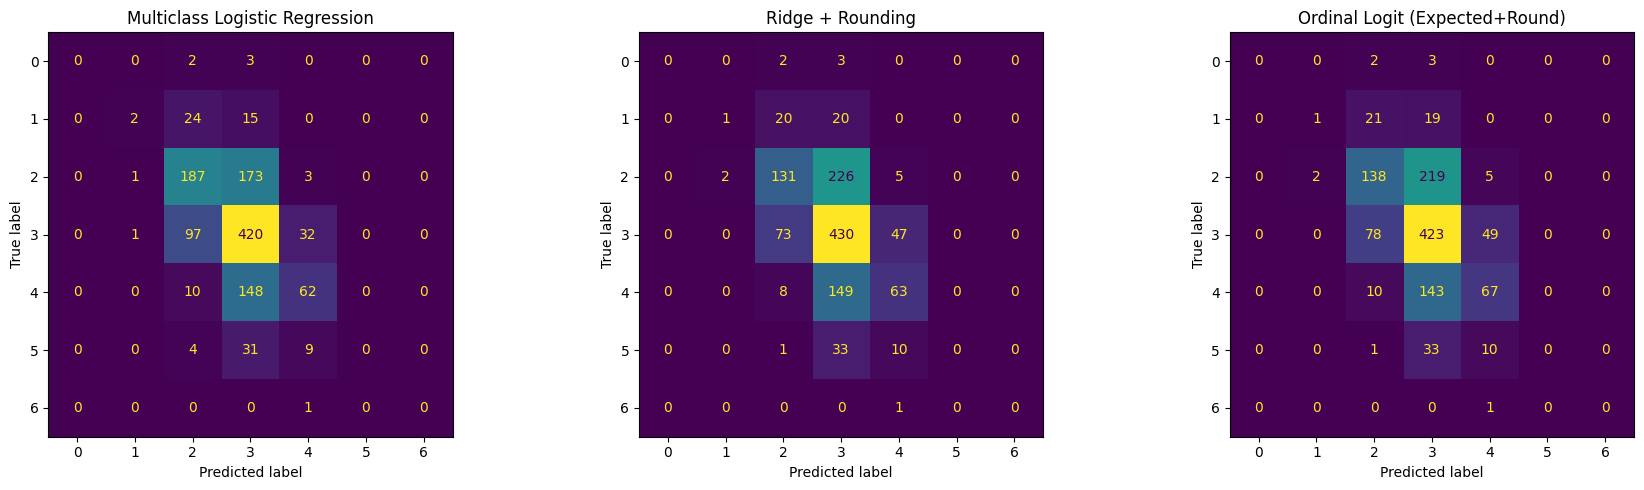

In [10]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay.from_predictions(y_test_shift, pred_mc, ax=axes[0], colorbar=False)
axes[0].set_title("Multiclass Logistic Regression")

ConfusionMatrixDisplay.from_predictions(y_test_shift, pred_reg, ax=axes[1], colorbar=False)
axes[1].set_title("Ridge + Rounding")

ConfusionMatrixDisplay.from_predictions(y_test_shift, pred_ord_exp, ax=axes[2], colorbar=False)
axes[2].set_title("Ordinal Logit (Expected+Round)")

plt.tight_layout()
plt.show()


### ۶.۵ تفسیر آستانه‌ها و ضرایب

- آستانه‌های $\theta_1,\dots,\theta_{K-1}$ محور امتیاز نهفته را به نواحی متناظر با سطوح تقسیم می‌کنند.
- مقدار پیش‌بین خطی $\eta = x^\top\beta$ جرم احتمال را (با قرارداد علامت این نوت‌بوک) به سمت سطوح بالاتر جابه‌جا می‌کند.

برای شهود:

- اگر $\eta$ افزایش یابد، $(\theta_k - \eta)$ کاهش می‌یابد.
- چون $\sigma$ افزایشی است، $\sigma(\theta_k - \eta)$ کاهش می‌یابد.
- بنابراین $P(Y \le k \mid x)$ کاهش یافته و جرم به سمت سطوح **بالاتر** می‌رود.

در نتیجه (طبق قرارداد این نوت‌بوک) ویژگی با $\beta_j$ **مثبت** تمایل به افزایش سطح پیش‌بینی‌شده دارد.

روال پیشنهادی برای تفسیر:

1. استانداردسازی ویژگی‌ها (انجام شد).
2. بررسی علامت و اندازه $\beta$:
   - $\beta_j$ بزرگ و مثبت → فشار به سمت سطوح بالاتر
   - $\beta_j$ بزرگ و منفی → فشار به سمت سطوح پایین‌تر
3. بررسی فاصله آستانه‌ها:
   - آستانه‌های خیلی نزدیک → دو سطح از دید مدل تقریباً یکی هستند
   - فاصله‌های خیلی بزرگ → عبور از آن مرز سخت‌تر است

در کاربردهای واقعی، آستانه‌ها مرزهای یک محور «کیفیت نهفته» را توضیح می‌دهند و ضرایب نشان می‌دهند هر ویژگی چگونه نمونه را روی این محور جابه‌جا می‌کند.


## ۷. مطالعه موردی B — House Prices (ساخت tierهای ترتیبی)

مسیر دیتاست: `../../../Datasets/Regression/house-prices.csv`

در این داده، هدف اصلی پیوسته است (**Price**). ما قیمت را به tierهای ترتیبی (quartile) تبدیل می‌کنیم تا یک سناریوی رایج را شبیه‌سازی کنیم:

- مقدار واقعی پیوسته است (قیمت),
- تصمیم/گزارش کسب‌وکار معمولاً با سبدها انجام می‌شود (low / mid-low / mid-high / high),
- ارزیابی باید ترتیب را منعکس کند.

این مثال تأکید می‌کند که مدل‌سازی ترتیبی فقط برای «امتیازدهی‌های نظرسنجی» نیست؛ هر جا تصمیم نهایی گسسته و **مرتب** باشد می‌تواند مناسب باشد.

گام‌ها:

1. بارگذاری داده،
2. ساخت tierهای ترتیبی از قیمت،
3. ساخت pipeline پیش‌پردازش (عددی + دسته‌ای),
4. برازش baselineها و مدل ترتیبی.


In [11]:
house_path = Path("../../../Datasets/Regression/house-prices.csv")
if not house_path.exists():
    raise FileNotFoundError(f"Could not find {house_path}. Please verify the repository structure and relative paths.")

house = pd.read_csv(house_path).dropna().copy()
house.head()


,Home,Price,SqFt,Bedrooms,Bathrooms,Offers,Brick,Neighborhood
0,1,114300,1790,2,2,2,No,East
1,2,114200,2030,4,2,3,No,East
2,3,114800,1740,3,2,1,No,East
3,4,94700,1980,3,2,3,No,East
4,5,119800,2130,3,3,3,No,East


In [12]:
# Create ordinal tiers using quartiles of the continuous target
house["Price"] = house["Price"].astype(float)
house["price_tier"] = pd.qcut(house["Price"], q=4, labels=[0, 1, 2, 3]).astype(int)

X_house = house.drop(columns=["Price", "price_tier"])
y_house = house["price_tier"]

print("Tier counts:")
print(y_house.value_counts().sort_index())


Tier counts:
price_tier
0    32
1    32
2    32
3    32
Name: count, dtype: int64


In [13]:
# Identify numeric and categorical columns
num_cols = X_house.select_dtypes(include=["number"]).columns.tolist()
cat_cols = [c for c in X_house.columns if c not in num_cols]

preprocess = ColumnTransformer(
    transformers=[
        ("num", StandardScaler(), num_cols),
        ("cat", OneHotEncoder(handle_unknown="ignore"), cat_cols),
    ],
    remainder="drop"
)

Xtr, Xte, ytr, yte = train_test_split(
    X_house, y_house, test_size=0.25, random_state=RANDOM_STATE, stratify=y_house
)

# Multiclass baseline pipeline
pipe_mc = Pipeline([
    ("prep", preprocess),
    ("clf", LogisticRegression(multi_class="multinomial", max_iter=5000, random_state=RANDOM_STATE))
])

pipe_mc.fit(Xtr, ytr)
pred_mc2 = pipe_mc.predict(Xte)

acc_mc2 = accuracy_score(yte, pred_mc2)
mae_mc2 = ordinal_mae(yte, pred_mc2)
qwk_mc2 = quadratic_weighted_kappa(yte, pred_mc2, n_classes=4)

print(f"House | Multiclass | Accuracy: {acc_mc2:.4f} | MAE: {mae_mc2:.4f} | QWK: {qwk_mc2:.4f}")


House | Multiclass | Accuracy: 0.5938 | MAE: 0.4688 | QWK: 0.7439


C:\Users\LENOVO.PIESC\AppData\Local\Programs\Python\Python313\Lib\site-packages\sklearn\linear_model\_logistic.py:1247: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. From then on, it will always use 'multinomial'. Leave it to its default value to avoid this warning.
  warnings.warn(


In [14]:
# Regression + rounding baseline
pipe_reg = Pipeline([
    ("prep", preprocess),
    ("reg", Ridge(alpha=1.0, random_state=RANDOM_STATE))
])

pipe_reg.fit(Xtr, ytr)
pred_reg2 = pipe_reg.predict(Xte)
pred_reg2 = clamp_int(np.rint(pred_reg2), 0, 3)

acc_reg2 = accuracy_score(yte, pred_reg2)
mae_reg2 = ordinal_mae(yte, pred_reg2)
qwk_reg2 = quadratic_weighted_kappa(yte, pred_reg2, n_classes=4)

print(f"House | Ridge+Round | Accuracy: {acc_reg2:.4f} | MAE: {mae_reg2:.4f} | QWK: {qwk_reg2:.4f}")


House | Ridge+Round | Accuracy: 0.6250 | MAE: 0.4062 | QWK: 0.7794


In [15]:
# Fit ordinal logit from scratch on the preprocessed design matrix
Xtr_m = preprocess.fit_transform(Xtr)
Xte_m = preprocess.transform(Xte)

# OneHotEncoder can produce sparse matrices; convert to dense for simplicity in this tutorial
if hasattr(Xtr_m, "toarray"):
    Xtr_m = Xtr_m.toarray()
    Xte_m = Xte_m.toarray()

res_house, beta_house, theta_house = fit_ordinal_logit(Xtr_m, ytr.values, n_classes=4, l2=1e-2, maxiter=600)
print("Converged:", res_house.success, "| Message:", res_house.message)
print("Thresholds (theta):", theta_house)

probs_house = predict_proba_ordinal(Xte_m, beta_house, theta_house)

# Expected rank + rounding
pred_house = np.rint((probs_house * np.arange(4)[None, :]).sum(axis=1)).astype(int)
pred_house = clamp_int(pred_house, 0, 3)

acc_o2 = accuracy_score(yte, pred_house)
mae_o2 = ordinal_mae(yte, pred_house)
qwk_o2 = quadratic_weighted_kappa(yte, pred_house, n_classes=4)

print(f"House | Ordinal Logit | Accuracy: {acc_o2:.4f} | MAE: {mae_o2:.4f} | QWK: {qwk_o2:.4f}")


Converged: True | Message: CONVERGENCE: REL_REDUCTION_OF_F_<=_FACTR*EPSMCH
Thresholds (theta): [-4.22036935 -0.80229719  3.1204817 ]
House | Ordinal Logit | Accuracy: 0.6250 | MAE: 0.4062 | QWK: 0.8026


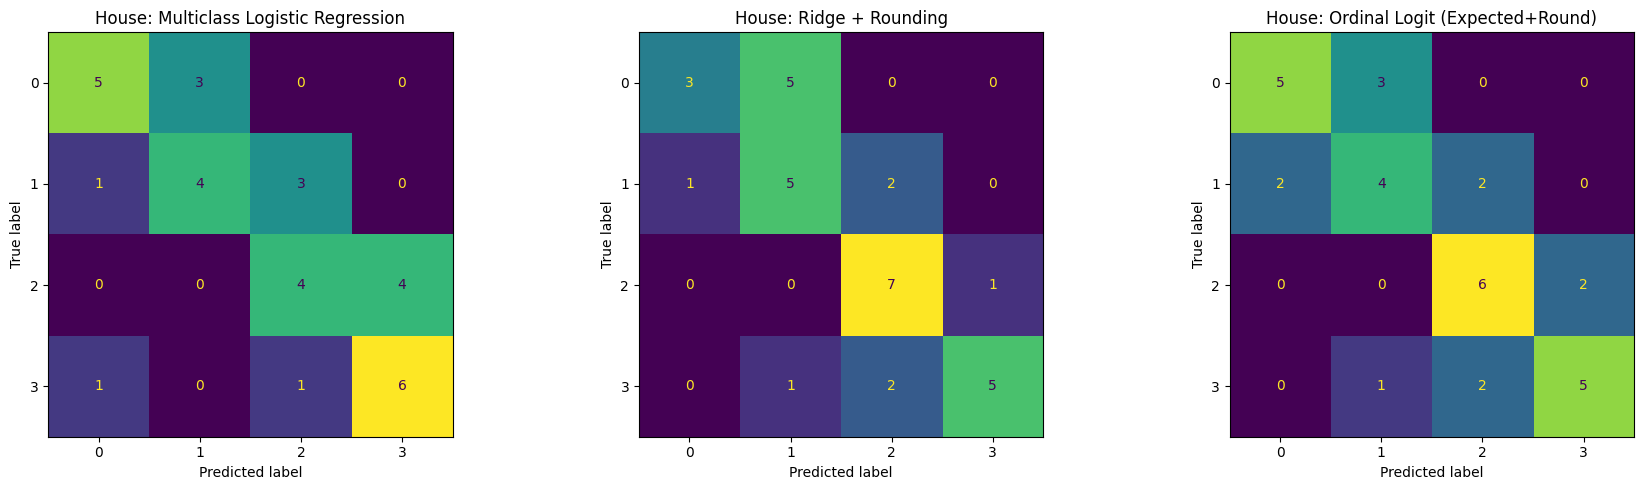

In [16]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

ConfusionMatrixDisplay.from_predictions(yte, pred_mc2, ax=axes[0], colorbar=False)
axes[0].set_title("House: Multiclass Logistic Regression")

ConfusionMatrixDisplay.from_predictions(yte, pred_reg2, ax=axes[1], colorbar=False)
axes[1].set_title("House: Ridge + Rounding")

ConfusionMatrixDisplay.from_predictions(yte, pred_house, ax=axes[2], colorbar=False)
axes[2].set_title("House: Ordinal Logit (Expected+Round)")

plt.tight_layout()
plt.show()


## ۸. نکات پیشرفته (مهم در پروژه‌های واقعی)

این بخش برای پروژه‌های جدی مهم است؛ چون رگرسیون ترتیبی اغلب در حوزه‌هایی به‌کار می‌رود که باید فرض‌ها قابل دفاع و توضیح‌پذیر باشند (مدیریت ریسک، پزشکی، آموزش).

### ۸.۱ آزمون فرض proportional odds

مدل cumulative link فرض می‌کند اثر $x$ روی همه مرزها یکسان است (parallel slopes).  
یعنی هر ویژگی نمونه را روی محور امتیاز نهفته به اندازه ثابت جابه‌جا می‌کند، مستقل از اینکه کدام مرز را نگاه کنید.

نشانه‌های نقض:

- تفکیک خوب برای مرزهای پایین ولی بد برای مرزهای بالا (یا بالعکس),
- کالیبراسیون ضعیف برای برخی رویدادهای تجمعی $Y \le k$,
- بهبود چشمگیر با مدل چندکلاسه انعطاف‌پذیر.

گزینه‌های عملی:

1. مدل‌های partial proportional odds (اگر در نرم‌افزار موجود باشد),
2. افزودن ویژگی‌های غیرخطی/تعامل‌ها,
3. استفاده از خانواده‌های دیگر ترتیبی (adjacent-category یا continuation-ratio),
4. یا بازگشت به multiclass وقتی تفسیرپذیری اولویت نیست و داده کافی دارید.

### ۸.۲ عدم‌توازن و سطح‌های نادر

در داده‌های ترتیبی معمولاً «میانه‌محور» هستند (نمونه‌های زیاد در وسط و کم در دو سر طیف). پیامدها:

- آستانه‌های سطوح نادر ناپایدار می‌شوند،
- accuracy ممکن است خوب به نظر برسد در حالی که مدل در تشخیص extremes ضعیف است.

راهکارها:

- ارزیابی جداگانه برای سطوح حدی,
- ادغام سطح‌های مجاور بسیار نادر (با تأیید دامنه),
- منظم‌سازی و جمع‌آوری داده هدفمند.

### ۸.۳ کالیبراسیون و تصمیم‌های آستانه‌ای

اگر تصمیم نهایی «حداقل سطح» باشد، مدل ترتیبی مستقیم می‌تواند:

$$
P(Y \ge k \mid x) = 1 - P(Y \le k-1 \mid x)
$$

را بدهد. بنابراین می‌توانید قواعدی مثل «پذیرش اگر tier ≥ 2 با احتمال ≥ 0.8» تعریف کنید.

وقتی تصمیم آستانه‌ای است، هم تصمیم را ارزیابی کنید (precision/recall) و هم خروجی ترتیبی را (MAE/QWK).

### ۸.۴ ارتباط با چند طبقه‌بند دودویی

برای هر $k$، مدل یک لجستیک دودویی روی رویداد $Y \le k$ القا می‌کند:

$$
\text{logit}(P(Y \le k \mid x)) = \theta_k - x^\top \beta.
$$

اما نکته کلیدی اشتراک $\beta$ در همه مرزهاست. همین اشتراک:

- ساختار ترتیب را وارد می‌کند،
- تعداد پارامترها را کم می‌کند،
- و خصوصاً در داده کم واریانس را کاهش می‌دهد.

### ۸.۵ اگر غیرخطی‌بودن لازم بود؟

دو الگوی رایج در ML کلاسیک:

1. ساخت نگاشت غیرخطی $\phi(x)$ (ویژگی‌های چندجمله‌ای، تبدیل‌های دامنه) و سپس برازش مدل ترتیبی روی $\phi(x)$
2. استفاده از مدل‌های درختی/ensemble با اهداف یا قیود monotonic/ordinal (بسته به کتابخانه). همیشه بررسی کنید که واقعاً ترتیب را رعایت می‌کند نه اینکه صرفاً برچسب‌ها را عددی فرض کند.

در فصل‌های مربوط به درخت‌ها و ensembleها دوباره به این موضوع برمی‌گردیم.


## ۹. تمرین‌ها

1. **تصمیم آستانه‌ای (دودویی از ترتیبی):**  
   با مدل ترتیبی wine، «کیفیت بالا» را $Y \ge 7$ تعریف کنید.  
   با امتیاز $P(Y \ge 7 \mid x)$ معیارهای precision/recall و ROC-AUC را محاسبه کنید.

2. **تحلیل خطا بر اساس فاصله:**  
   برای هر مدل، توزیع خطا $e_i = \hat{y}_i - y_i$ را بسازید.  
   کدام مدل خطاهای بزرگ‌مقدار کمتری دارد؟

3. **ادغام کلاس‌های نادر:**  
   در دیتاست wine، امتیازهای پایین نادر را ادغام کنید (مثلاً ۰–۴ → ۰).  
   مدل‌ها را دوباره آموزش دهید و QWK و MAE را مقایسه کنید.

4. **جست‌وجوی منظم‌سازی:**  
   برای مدل ترتیبی، $\lambda$ را روی یک شبکه مقداردهی کنید و نمودار MAE برحسب $\lambda$ رسم کنید.

5. **قاعده پیش‌بینی جایگزین:**  
   قاعده «میانه» را پیاده‌سازی کنید: کوچک‌ترین $k$ که $P(Y \le k) \ge 0.5$.  
   آن را با MAP و Expected+Round از نظر MAE/QWK مقایسه کنید.

6. **حساسیت ویژگی‌ها:**  
   برای مدل ترتیبی، حساسیت پیش‌بینی رتبه مورد انتظار نسبت به هر ویژگی را اطراف میانگین با finite difference محاسبه کنید.  
   با قدرمطلق ضرایب استانداردشده مقایسه کنید.

7. **گسترش به دیتاست دیگر:**  
   یکی از `../../../Datasets/Regression/diamonds.csv` یا `../../../Datasets/Regression/salaries.csv` را انتخاب کنید، هدف پیوسته را به ۵ tier ترتیبی تبدیل کنید، و همین روال را تکرار کنید.

## ۱۰. جمع‌بندی

- رگرسیون ترتیبی وقتی مناسب است که برچسب‌ها گسسته و **مرتب** باشند.
- رفتار مثل multiclass ترتیب را نادیده می‌گیرد؛ رفتار مثل رگرسیون فاصله برابر را تحمیل می‌کند. هر دو baseline مفیدند.
- مدل cumulative link (proportional odds):

  $$P(Y \le k \mid x) = \sigma(\theta_k - x^\top \beta)$$

  ترتیب را با آستانه‌های صعودی و ضرایب مشترک وارد مدل می‌کند.
- معیارهای ترتیبی (MAE روی رتبه‌ها، QWK) ارزیابی دقیق‌تری از شدت خطا می‌دهند.
- در عمل، با کلاس‌های نادر با احتیاط برخورد کنید، اعتبارسنجی درست انجام دهید، و معیار را با تصمیم نهایی هم‌راستا نگه دارید.
